In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import infomap           as im
import matplotlib.pyplot as plt
import networkx          as nx
import numpy             as np
import seaborn           as sb

from analysis import *
from scipy.stats import entropy, kendalltau
from sklearn.metrics import adjusted_mutual_info_score

In [2]:
colours = ["windows blue", "amber", "pale red", "greyish", "faded green", "dusty purple", "orange"]

sb.set()
sb.set_style("whitegrid", {'grid.linestyle': '--'}),
sb.set_palette(sb.xkcd_palette(colours))

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

# Create LFR network

In [4]:
n    = 1000
tau1 = 2.5
tau2 = 1.5
mu   = 0.1
G = nx.generators.community.LFR_benchmark_graph( n              = 1000
                                               , tau1           =    2.5
                                               , tau2           =    1.5
                                               , mu             =    0.1
                                               , average_degree =   10
                                               , min_community  =  100
                                               , seed           =   42
                                               )

In [5]:
# ground truth community assignments
communities = { frozenset(G.nodes[v]["community"]) for v in G }

community_assignments = dict()
for (m, nodes) in enumerate(communities):
    for node in nodes:
        community_assignments[node] = m

# ground truth labels
y_true = [community_assignments[u] for u in G.nodes]

In [6]:
# detect communities with infomap
info = im.Infomap(silent = True, two_level = True, num_trials = 100)
info.add_networkx_graph(G)
info.run()

In [7]:
# extract communities from infomap
M = dict()
for (u, m) in info.get_modules().items():
    if m not in M:
        M[m] = set()
    M[m].add(u)

inferred = { frozenset(v) for v in M.values() }

In [8]:
# check if infomap finds the ground truth
inferred == communities

True

In [9]:
ranking_original = sorted( [ (node.node_id, node.modular_centrality) for node in info.iterLeafNodes() ]
                         , key     = lambda p: p[1]
                         , reverse = True
                         )
ranking_original = [ node for (node,_) in ranking_original ]

# Rewiring and checking communities

In [10]:
ps   = [0.05 * p for p in range(21)]
amis = []
taus = []
mus  = []
num_communities = []
effect_communities = []

np.random.seed(42)

# for all fractions of rewiring
for p in ps:
    amis_tmp = []
    taus_tmp = []
    mus_tmp  = []
    num_communities_tmp = []
    effect_communities_tmp = []
    
    # repeat 100 times per rewiring fraction
    for _ in range(100):
        # one swap requires two edges, so the number of swaps
        # has to be half of the fraction of edges we want to swap
        G_ = nx.algorithms.swap.double_edge_swap( G         = G.copy()
                                                , nswap     = int(0.5 * p * G.number_of_edges())
                                                , max_tries = G.number_of_edges()
                                                , seed      = np.random.randint(1e6))

        # detect communities after rewiring
        info_ = im.Infomap(silent = True, two_level = True, num_trials = 100)
        info_.add_networkx_graph(G_)
        info_.run()
        
        # and extract the new community structure
        M_ = dict()
        for (u, m) in info_.get_modules().items():
            if m not in M_:
                M_[m] = set()
            M_[m].add(u)

        community_assignments_ = dict()
        for (m, nodes) in M_.items():
            for node in nodes:
                community_assignments_[node] = m
        
        # calculate mixing
        intra_links = 0
        inter_links = 0

        for (u,v) in G.edges:
            if community_assignments_[u] == community_assignments_[v]:
                intra_links += 1
            else:
                inter_links += 1

        mu = inter_links / (inter_links + intra_links)
        mus_tmp.append(mu)

        # AMI and tau
        y_pred = [community_assignments_[u] for u in G.nodes]
        amis_tmp.append(adjusted_mutual_info_score(labels_true = y_true, labels_pred = y_pred))

        ranking_rewired = sorted( [ (node.node_id, node.modular_centrality) for node in info_.iterLeafNodes() ]
                                , key     = lambda p: p[1]
                                , reverse = True
                                )
        ranking_rewired = [ node for (node,_) in ranking_rewired ]
        
        taus_tmp.append(kendalltau(ranking_original, ranking_rewired).correlation)
        
        # number of communities and effective number of communities
        num_communities_tmp.append(len(M_))
        effect_communities_tmp.append(2**entropy([len(m) for m in M_.values()], base = 2))
    
    amis.append(np.average(amis_tmp))
    taus.append(np.average(taus_tmp))
    mus.append(np.average(mus_tmp))
    num_communities.append(np.average(num_communities_tmp))
    effect_communities.append(np.average(effect_communities_tmp))

/tmp/ipykernel_2260128/2824712371.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(["0.0","0.2","0.4","0.6","0.8","1.0"], fontsize = 16)
/tmp/ipykernel_2260128/2824712371.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["0.0","0.2","0.4","0.6","0.8","1.0"], fontsize = 16)


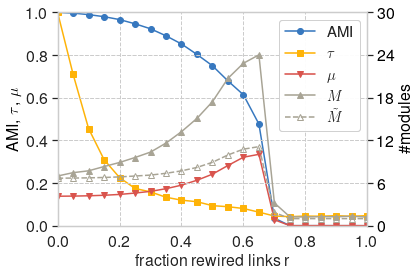

In [11]:
fig, ax1 = plt.subplots(1,1,figsize=(6,4))

ax1.set_yticklabels(["0.0","0.2","0.4","0.6","0.8","1.0"], fontsize = 16)
ax1.set_xticklabels(["0.0","0.2","0.4","0.6","0.8","1.0"], fontsize = 16)
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xlabel("fraction rewired links r", fontsize = 16)
ax1.set_ylabel("AMI, $\\tau$, $\\mu$", color = 'black', fontsize = 16)
p1, = ax1.plot(ps, amis, color = sb.color_palette()[0], marker = "o")
p2, = ax1.plot(ps, taus, color = sb.color_palette()[1], marker = "s")
p3, = ax1.plot(ps, mus,  color = sb.color_palette()[2], marker = "v")
#ax1.tick_params(axis ='y', labelcolor = 'red')

ax2 = ax1.twinx()
ax2.set_yticks([0, 6, 12, 18, 24, 30])
ax2.set_yticklabels(["0","6","12","18","24","30"], fontsize = 16)
ax2.set_ylim(0,30)
ax2.set_ylabel("\#modules", color = "black", fontsize = 16)
p4, = ax2.plot(ps, num_communities, color = sb.color_palette()[3], marker = "^")
p5, = ax2.plot(ps, effect_communities, color = sb.color_palette()[3], marker = "^", fillstyle = "none", linestyle = "--")
ax2.tick_params(axis ='y', labelcolor = "black")

l1 = plt.legend([p1,p2,p3,p4,p5], ["AMI", "$\\tau$", "$\\mu$", "$M$", "$\\tilde{M}$"], fontsize = 15, loc = 1)
plt.gca().add_artist(l1)
plt.tight_layout()
plt.savefig("../plots/LFR.pdf")

In [12]:
!pdfcrop ../plots/LFR.pdf
!mv ../plots/LFR-crop.pdf ../plots/LFR.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/LFR-crop.pdf'.
